In [ ]:
import gdal
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from keras import layers
from keras.layers import Input, BatchNormalization, Conv2D, UpSampling2D, concatenate
from keras.layers import MaxPooling2D
from keras.models import Model
from tensorflow.keras.backend import pool2d
from keras import backend as K
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

Using TensorFlow backend.


Extract the Dataset

In [ ]:
!p7zip -d -k '/content/drive/My Drive/Copy of WaterWays_dataset.7z'


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/drive/My Drive/                                  1 file, 68211857 bytes (66 MiB)

Extracting archive: /content/drive/My Drive/Copy of WaterWays_dataset.7z
--
Path = /content/drive/My Drive/Copy of WaterWays_dataset.7z
Type = 7z
Physical Size = 68211857
Headers Size = 17600
Method = LZMA2:24
Solid = +
Blocks = 1

  0%      1% 3        4% 45 - WaterWays/WaterWays_FCC/1035.tif                                            8% 88 - WaterWays/WaterWays_FCC/1074.tif                                          

Read The Images

In [ ]:
data_FCC_train = np.full((1080,3,128,128),0)
for i in range(0,1080):
  raster_ds = gdal.Open("/content/WaterWays/WaterWays_FCC/{}.tif".format(i), gdal.GA_ReadOnly)
  for j in range(1,4):
    data_FCC_train[i][j-1] = raster_ds.GetRasterBand(j).ReadAsArray()
data_FCC_train=np.swapaxes(data_FCC_train,1,3)

data_GT_train = np.full((1080,1,128,128),0)
for i in range(0,1080):
  raster_ds = gdal.Open("/content/WaterWays/WaterWays_GT/{}.tif".format(i), gdal.GA_ReadOnly)
  data_GT_train[i][0] = raster_ds.GetRasterBand(1).ReadAsArray()

data_GT_train=np.swapaxes(data_GT_train,1,3)


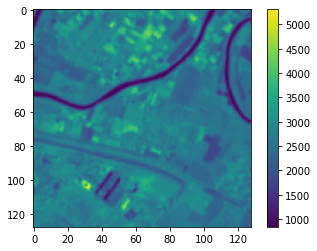

In [ ]:
plt.imshow(np.swapaxes(data_FCC_train[805],0,2)[0])
plt.colorbar()
plt.show()

In [ ]:
data_GT_train[1].shape

(128, 128, 1)

In [ ]:
a=[]
for i in range(0,1080):
  if(data_GT_train[i].any()==True):
    a.append(i)
a

[4,
 9,
 10,
 11,
 12,
 14,
 16,
 17,
 18,
 19,
 20,
 27,
 32,
 33,
 34,
 35,
 36,
 37,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 47,
 48,
 54,
 55,
 56,
 57,
 58,
 59,
 63,
 64,
 66,
 67,
 68,
 75,
 76,
 77,
 79,
 80,
 83,
 88,
 89,
 90,
 91,
 92,
 94,
 95,
 105,
 106,
 107,
 108,
 109,
 110,
 111,
 115,
 116,
 117,
 118,
 119,
 121,
 122,
 136,
 137,
 138,
 143,
 144,
 145,
 146,
 148,
 149,
 162,
 163,
 164,
 165,
 166,
 167,
 169,
 170,
 172,
 175,
 176,
 190,
 191,
 192,
 193,
 194,
 195,
 196,
 197,
 198,
 199,
 218,
 219,
 223,
 225,
 226,
 233,
 234,
 245,
 246,
 250,
 251,
 259,
 260,
 261,
 262,
 263,
 272,
 273,
 274,
 276,
 277,
 278,
 279,
 280,
 283,
 284,
 285,
 286,
 287,
 288,
 289,
 292,
 300,
 301,
 302,
 303,
 313,
 314,
 317,
 318,
 319,
 324,
 325,
 326,
 327,
 328,
 329,
 330,
 339,
 340,
 341,
 342,
 343,
 344,
 345,
 346,
 347,
 353,
 354,
 355,
 356,
 357,
 358,
 359,
 360,
 362,
 365,
 366,
 367,
 368,
 369,
 374,
 375,
 383,
 384,
 386,
 387,
 389,
 390,
 392,
 39

Creating Model

In [ ]:
class MinPooling2D(layers.MaxPooling2D):


  def __init__(self, pool_size=(2, 2), strides=None, 
               padding='valid', data_format=None, **kwargs):
    super(MaxPooling2D, self).__init__(pool_size, strides, padding,
                                       data_format, **kwargs)

  def pooling_function(inputs, pool_size, strides, padding, data_format):
    return -K.pool2d(-inputs, pool_size, strides, padding, data_format,
                                                         pool_mode='max')

In [ ]:
img_input = Input(shape=(128,128,3))


conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(img_input)
#conv1 = Dropout(0.2)(conv1)
conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
conv1 = BatchNormalization()(conv1)
pool1 = MinPooling2D((4, 4))(conv1)

conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
#conv2 = Dropout(0.2)(conv2)
conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
conv2 = BatchNormalization()(conv2)
pool2 = MinPooling2D((4, 4))(conv2)


conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
conv3 = BatchNormalization()(conv3)
#conv3 = Dropout(0.2)(conv3)
conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
conv3 = BatchNormalization()(conv3)

up1 = concatenate([UpSampling2D((4, 4))(conv3), conv2], axis=-1)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(up1)
#conv4 = Dropout(0.2)(conv4)
conv4 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv4)
conv4 = BatchNormalization()(conv4)

up2 = concatenate([UpSampling2D((4, 4))(conv4), conv1], axis=-1)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(up2)
#conv5 = Dropout(0.2)(conv5)
conv5 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5)
conv5 = BatchNormalization()(conv5)

out = Conv2D(1, (1, 1) , activation='sigmoid', padding='same')(conv5)


model = Model(inputs=[img_input], outputs=[out])

In [ ]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 128, 128, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 128, 128, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 128, 128, 32) 9248        conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 128, 128, 32) 128         conv2d_2[0][0]                   
____________________________________________________________________________________________

Train the Model

In [ ]:
FCC_Train,FCC_Test,GT_Train,GT_Test = train_test_split(data_FCC_train,
                                                             data_GT_train, 
                                                             test_size=0.1, 
                                                             random_state=0
                                                          )

In [ ]:
print(FCC_Train.shape[0],FCC_Test.shape[0])

855 108


In [ ]:
FCC_Train,FCC_Validation,GT_Train,GT_Validation = train_test_split(FCC_Train,
                                                             GT_Train, 
                                                             test_size=0.12, 
                                                             random_state=0
                                                          )

In [ ]:
print(FCC_Train.shape[0],FCC_Validation.shape[0])

844 149


In [ ]:
model.compile(loss='binary_crossentropy',
        optimizer='Adam',
        metrics=['accuracy'])

In [ ]:
test = model.fit(FCC_Train, GT_Train,epochs=200,verbose=1,validation_data=(FCC_Validation, GT_Validation))

Train on 855 samples, validate on 117 samples
Epoch 1/200
855/855 [==============================] - 10s 12ms/step - loss: 0.6656 - accuracy: 0.7547 - val_loss: 0.3188 - val_accuracy: 0.9015
Epoch 2/200
855/855 [==============================] - 2s 3ms/step - loss: 0.5549 - accuracy: 0.9882 - val_loss: 0.4288 - val_accuracy: 0.9522
Epoch 3/200
855/855 [==============================] - 2s 3ms/step - loss: 0.4515 - accuracy: 0.9966 - val_loss: 0.3895 - val_accuracy: 0.9830
Epoch 4/200
855/855 [==============================] - 2s 3ms/step - loss: 0.3469 - accuracy: 0.9970 - val_loss: 0.2895 - val_accuracy: 0.9895
Epoch 5/200
855/855 [==============================] - 2s 3ms/step - loss: 0.2551 - accuracy: 0.9971 - val_loss: 0.2128 - val_accuracy: 0.9910
Epoch 6/200
855/855 [==============================] - 2s 3ms/step - loss: 0.1845 - accuracy: 0.9971 - val_loss: 0.1519 - val_accuracy: 0.9965
Epoch 7/200
855/855 [==============================] - 2s 3ms/step - loss: 0.1346 - accuracy: 

Plotting the Graph

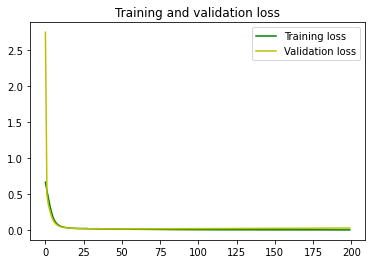

In [ ]:
loss = test.history['loss']
val_loss = test.history['val_loss']
epochs = range(0,200)
plt.figure()
plt.plot(epochs, loss, 'g-', label='Training loss')
plt.plot(epochs, val_loss, 'y-', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

Predicting the FCC images

In [ ]:
mx = model.predict(data_FCC_train[0:1080],verbose=1)


1080/1080 [==============================] - 1s 1ms/step


In [ ]:
for i in range(972,1080):
  for j in range(0,128):
    for k in range(0,128):
      if(mx[i][j][k]>0.2):
        mx[i][j][k]=1
      else:
        mx[i][j][k]=0
  clear_output(wait=True)
  print("Checking : ",round((i/1079)*100,3),"%")

Checking :  100.0 %


In [ ]:
mx=np.swapaxes(mx,1,3)
y=np.swapaxes(data_GT_train,1,3)

In [ ]:
from sklearn.metrics import r2_score
h = 0 
for i in range(855,1080):
  h = h + r2_score(y[i][0],mx[i][0])
h = h/(1080-855)
h

0.9681127506801913

In [ ]:
TP = TN = FP = FN = JAR = 0
for k in range(972,1080):
  T_P = T_N = F_P = F_N = tot = 0
  for i in range(0,128):
    for j in range(0,128):
      if((mx[k][0][i][j] == y[k][0][i][j]) and (y[k][0][i][j] == 1)):
        T_P = T_P+1
      if((mx[k][0][i][j] == y[k][0][i][j]) and (y[k][0][i][j] == 0)):
        T_N = T_N+1
      if(mx[k][0][i][j] > y[k][0][i][j]):
        F_P = F_P+1
      if(mx[k][0][i][j] < y[k][0][i][j]):
        F_N = F_N+1
      
  TP = TP+T_P
  TN = TN+T_N
  FP = FP+F_P
  FN = FN+F_N
  clear_output(wait=True)
  print("Calculating : ",round(((k-855)/(1079-855))*100,3),"%")

accuracy = ((TP+TN)/(TP+FP+TN+FN))*100
precision = (TP/(TP+FP))*100
recall = (TP/(TP+FN))*100
f1score = ((2*precision*recall)/(precision+recall))
accuracy, precision, recall, f1score

Calculating :  100.0 %


(99.93715639467592, 82.01727328809378, 83.40652446675031, 82.70606531881805)

In [ ]:
mx = np.swapaxes(mx,1,3)

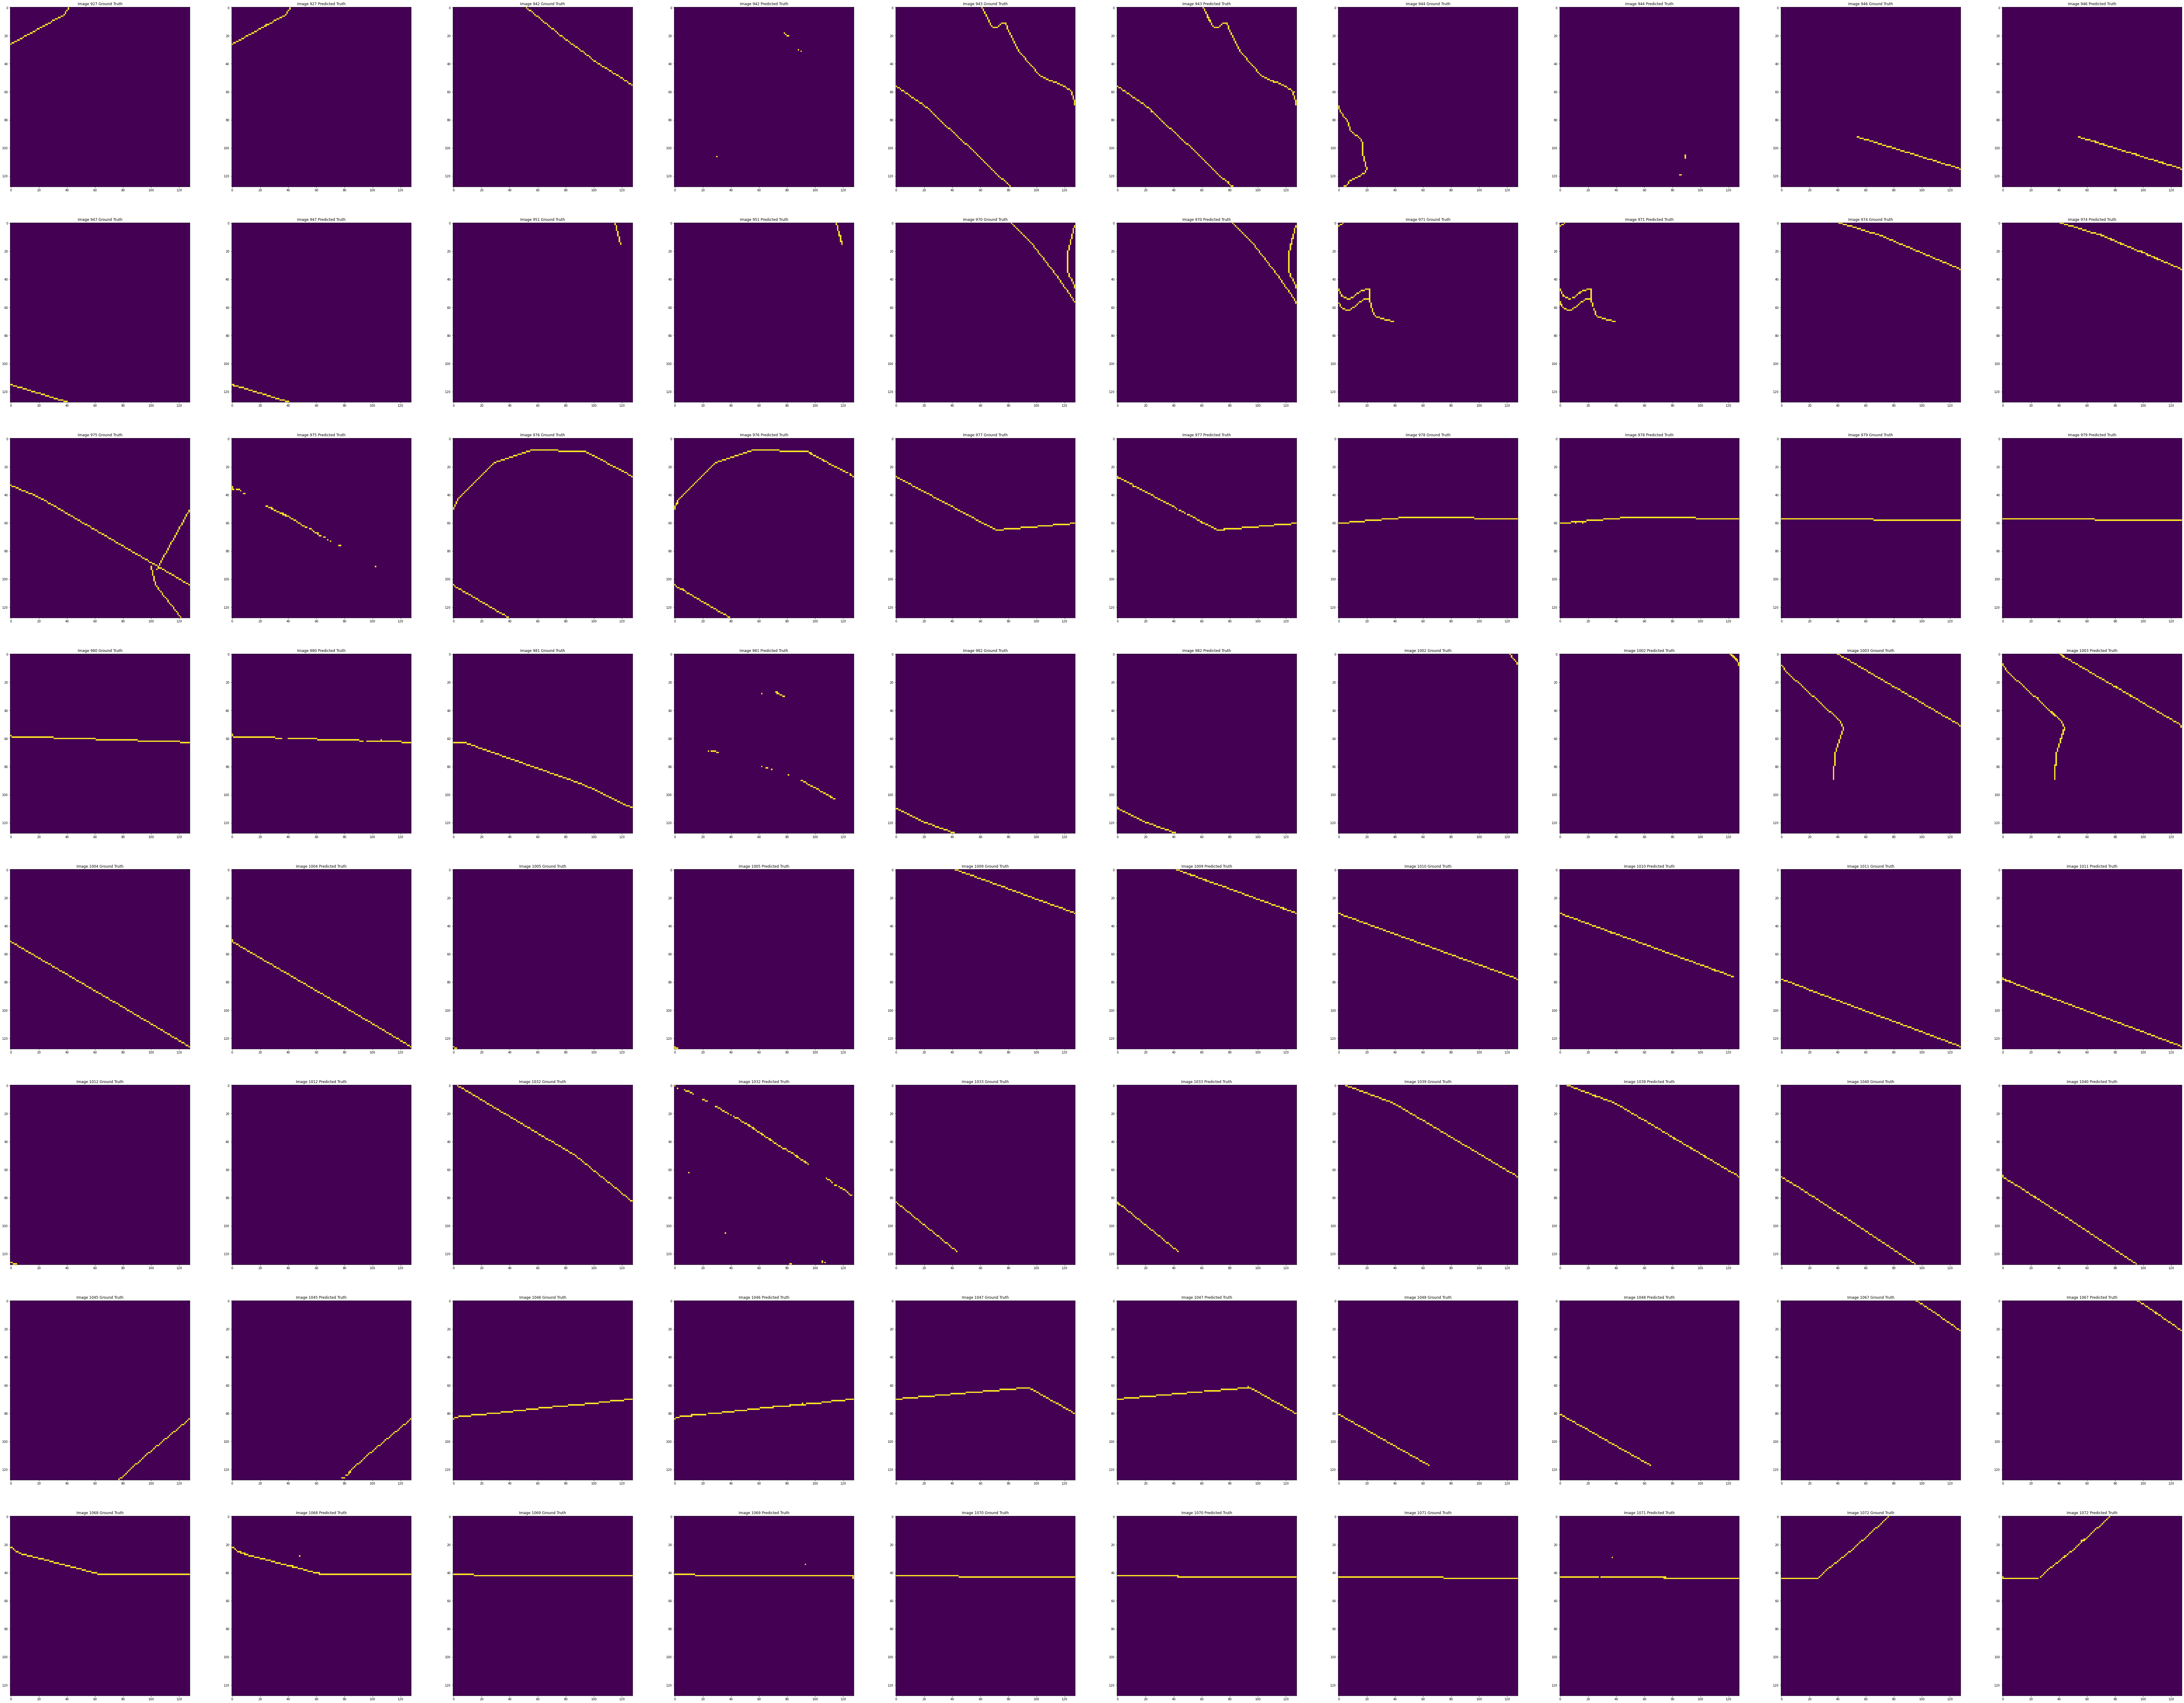

In [ ]:
fig=plt.figure(figsize=(128, 128))
columns = 10
rows = 10
i=1
for j in a[431:471]:
    img1 = data_GT_train[j][:,:,0]
    fig.add_subplot(rows, columns, i)
    i+=1
    plt.title("Image {} Ground Truth".format(j))
    plt.imshow(img1)
    
    img1 = mx[j][:,:,0]
    fig.add_subplot(rows, columns, i)
    i+=1
    plt.title("Image {} Predicted Truth".format(j))
    plt.imshow(img1)
plt.show()

In [ ]:
848, 849, 859, 860, 861, 862, 874, 875, 887,889, 890, 900, 901,

In [ ]:
i=1071

Predicted Output

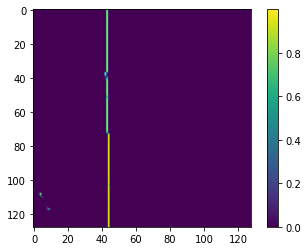

In [ ]:
plt.imshow(mx[i][0])
plt.colorbar()
plt.show()


Expected Output

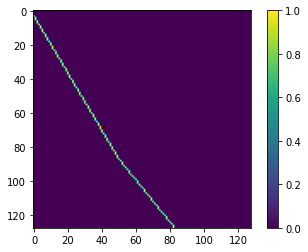

In [ ]:
plt.imshow(y[i][0])
plt.colorbar()  
plt.show()



In [ ]:
model.evaluate(data_FCC_train[844:1080],data_GT_train[844:1080])

236/236 [==============================] - 0s 1ms/step


[0.005029635634115439, 0.9993650913238525]